## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2

Using plaidml.keras.backend backend.


Now let's explore some of the data, for starters we will use the following Kaggle dataset: [lego-brick-images](https://www.kaggle.com/joosthazelzet/lego-brick-images)

It's a fairly simple dataset containing renders of some LEGO pieces

In [3]:
os.listdir("../../LEGO_brick_custom")

['18575 Double conical wheel Z20 1M',
 '2340 Rudder 1x4x3',
 '2357 Brick corner 1x2x2',
 '2420 Plate corner 2x2',
 '3001 Brick 2x4',
 '3003 Brick 2x2',
 '3004 Brick 1x2',
 '3005 Brick 1x1',
 '3010 Brick 1x4',
 '3020 Plate 2x4',
 '3022 Plate 2x2',
 '3023 Plate 1x2',
 '3024 Plate 1x1',
 '3037 Roof tile 2x4',
 '3040 Roof tile 1x2x45deg',
 '32140 Technic angled beam 4x2 90Deg',
 '3298 Roof tile 2x3',
 '4083 Hanger 1x4x2',
 '41678 Cross block fork 2x2',
 '4276 Worm',
 '4286 Roof tile 1x3',
 '4864 Wall element 1x2x2',
 '6143 Brick D16 with cross',
 '6632 Lever 3M',
 '99301 Roof tile inside 3x3']

In [4]:
len(os.listdir("../../LEGO_brick_custom"))

25

The first numbers denote the brick model, after that is it's name, size and possible modifications

In [5]:
os.listdir("../../LEGO_brick_custom/3003 Brick 2x2/")[:10]

['test_0_0.png',
 'test_0_1.png',
 'test_0_10.png',
 'test_0_11.png',
 'test_0_12.png',
 'test_0_13.png',
 'test_0_14.png',
 'test_0_15.png',
 'test_0_16.png',
 'test_0_17.png']

We can see that the folder are filled with individual .png files, these are loadable in Keras.

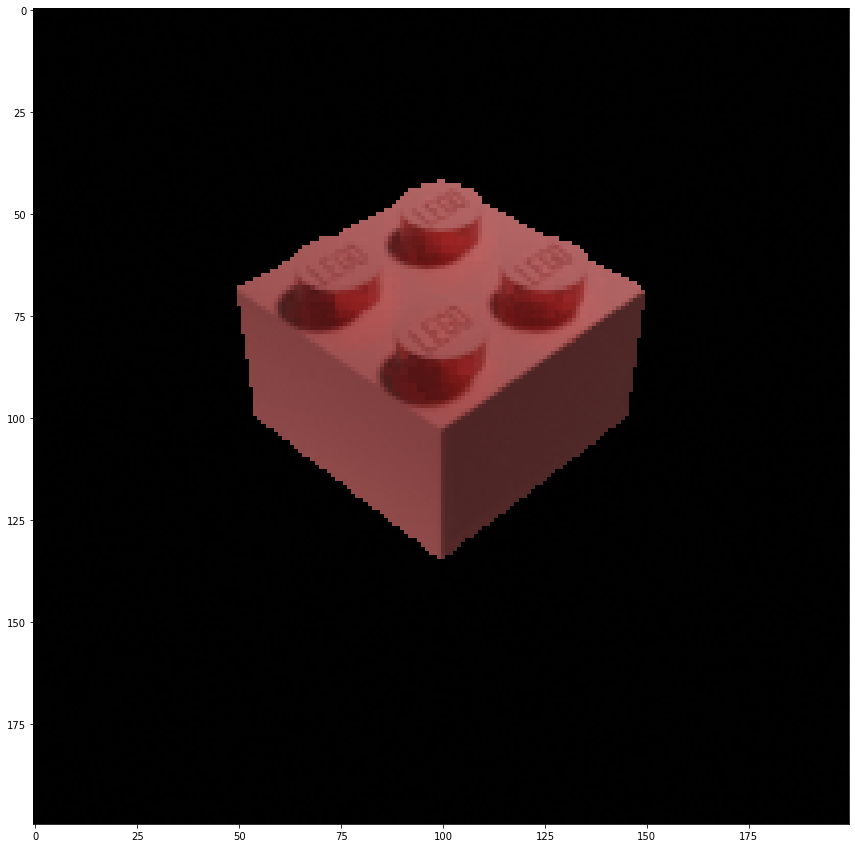

In [3]:
image_path = "../../LEGO_brick_custom/3003 Brick 2x2/test_6_40.png"
image = cv2.imread(image_path)
plt.figure(figsize=(15,15))
plt.imshow(image)

In [4]:
image.shape

(200, 200, 3)

To try to load the data into Keras, we must first create a subset for training and validation

In [5]:
dataset_path = "../../LEGO_brick_custom/"
dataset_output = "./output"

In [6]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [7]:
def crop_random_shape_from_image(image: np.ndarray, cutter_shape: tuple = (200,200), verbose: bool = False) -> np.ndarray:
    '''Crop a randomly placed cutter_shape sized box from given image and returns it'''
    if(verbose):
        print(image.shape)
        print(cutter_shape)

    shape = image.shape

    if(cutter_shape[0] > shape[0] or cutter_shape[1] > shape[1]):
        raise ValueError("Cutter shape ", cutter_shape, " larger than one or more dimensions of given picture shape", shape[:2])
    
    x_1 = np.random.randint(0, shape[0] - cutter_shape[0])
    x_2 = x_1 + cutter_shape[0]

    y_1 = np.random.randint(0, shape[1] - cutter_shape[1])
    y_2 = y_1 + cutter_shape[1]

    if(verbose):
        print(x_1, x_2, y_1, y_2)
    
    result = image[x_1:x_2, y_1:y_2]
    
    return result

def overlay_transparent(background, overlay, x = 0, y = 0):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        raise ValueError("UwU")

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        raise ValueError("Not transparent")

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:]

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

In [13]:
class Background_source:

    def load_images(self):
        for img in os.listdir(self.path):
            img = cv2.imread(os.path.join(self.path, img))
            if(img is not None):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                self.background_images.append(img)
    
    def __init__(self, directory_path:str, crop_shape:tuple=(200,200), blur_kernel:tuple=(3,3)):
        self.path = directory_path
        self.crop_shape = crop_shape
        self.blur_kernel = blur_kernel
        self.background_images = []

        self.load_images()
    
    def apply_background(self, image):
        background = crop_random_shape_from_image(self.background_images[np.random.randint(len(self.background_images))], self.crop_shape)
        background = cv2.blur(background, self.blur_kernel)
        background = np.asarray(background, np.float32)
        background = background[:,:] / 255

        result = overlay_transparent(background, image / 255)

        alpha = np.ones(result.shape[:2])
        result = np.dstack((result, alpha)).astype(np.float32)
        result = result * 255

        return result

In [37]:
from keras.preprocessing.image import ImageDataGenerator

bg = Background_source("../../background_images", (200,200), (3,3))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=10,
    zoom_range=[1,1.2],
    height_shift_range=0.2,
    width_shift_range=0.2,
    brightness_range=[0.6,1],
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = bg.apply_background
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = bg.apply_background
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), color_mode="rgba", target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), color_mode="rgba", target_size=(200,200), shuffle=True, class_mode='categorical')


print(len(train_generator.class_indices))

Found 26875 images belonging to 25 classes.
Found 11525 images belonging to 25 classes.
25


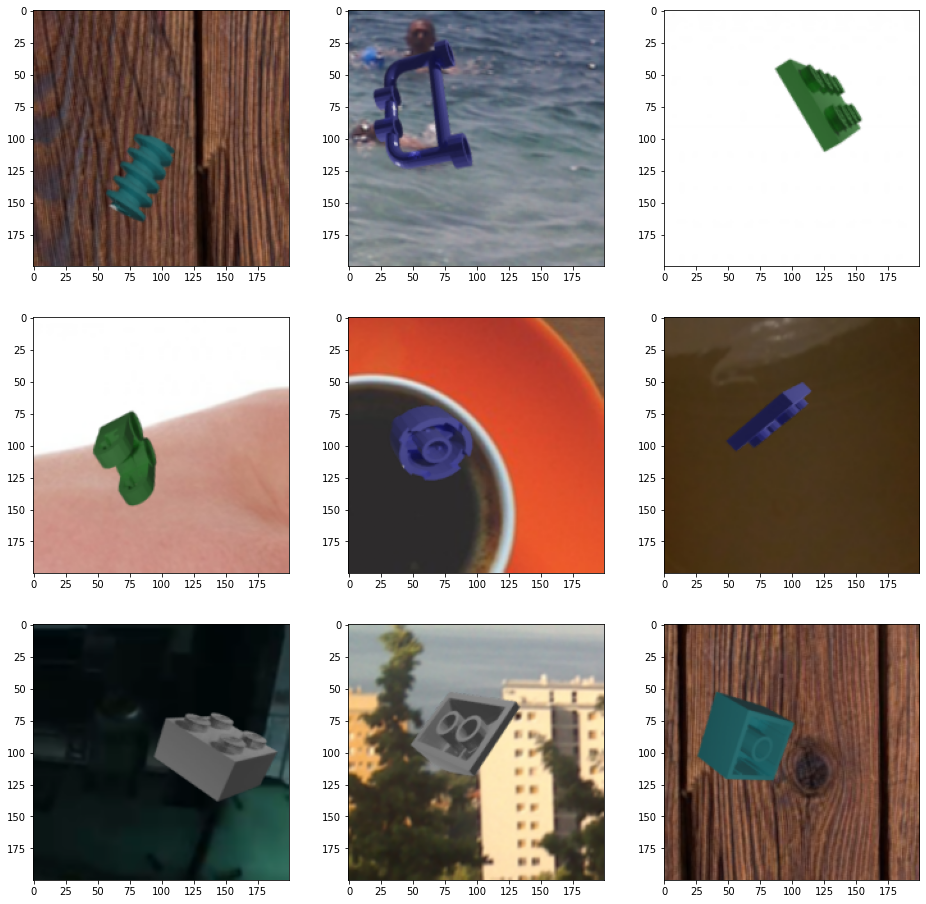

In [15]:
plt.figure(figsize=(16,16))
batch = train_generator.next()
for i in range(9):
    plt.subplot(330+1+i)
    plt.imshow(batch[0][i])
plt.show()


Now to declare a model and modify it, we can also use preexisting ones like VGG16 or ResNet but for this test we are using a simple one

In [38]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Sequential, Model

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(200,200,4), activation="relu"))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 198, 198, 32)      1184      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 98, 98, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 307328)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                19669056  
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 25)                1625      
Total para

In [30]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="model/model_vertical.png", show_shapes = True)
plot_model(model, to_file="model/model_horizontal.png", show_shapes = True, rankdir="LR")

In [39]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau
from datetime import datetime

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=16,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=4,
    verbose=1, 
    mode='auto',
    cooldown=1 
)


#https://keras.io/guides/writing_your_own_callbacks/
class timeCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        _time = datetime.now()
        print(_time.strftime("%H:%M:%S"))

callbacks = [checkpoint, tensorboard, csvlogger, reduce, earlystop, timeCallback()]

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [40]:
from keras.optimizers import SGD

opt = SGD(lr=1e-2) #dobar za plitke mreže
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator, 
    validation_data  = validation_generator,
    epochs = 100, 
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

Epoch 1/100
840/840 [==============================] - 775s 923ms/step - loss: 3.2199 - acc: 0.0407 - val_loss: 3.2138 - val_acc: 0.0519

Epoch 00001: val_loss improved from inf to 3.21377, saving model to ./base.model
11:29:46
Epoch 2/100
840/840 [==============================] - 727s 865ms/step - loss: 3.2111 - acc: 0.0467 - val_loss: 3.1940 - val_acc: 0.0533

Epoch 00002: val_loss improved from 3.21377 to 3.19398, saving model to ./base.model
11:41:54
Epoch 3/100
840/840 [==============================] - 688s 820ms/step - loss: 3.1895 - acc: 0.0528 - val_loss: 3.1318 - val_acc: 0.0629

Epoch 00003: val_loss improved from 3.19398 to 3.13185, saving model to ./base.model
11:53:23
Epoch 4/100
840/840 [==============================] - 690s 822ms/step - loss: 3.1354 - acc: 0.0668 - val_loss: 3.0037 - val_acc: 0.0898

Epoch 00004: val_loss improved from 3.13185 to 3.00372, saving model to ./base.model
12:04:55
Epoch 5/100
840/840 [==============================] - 683s 813ms/step - los

In [41]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

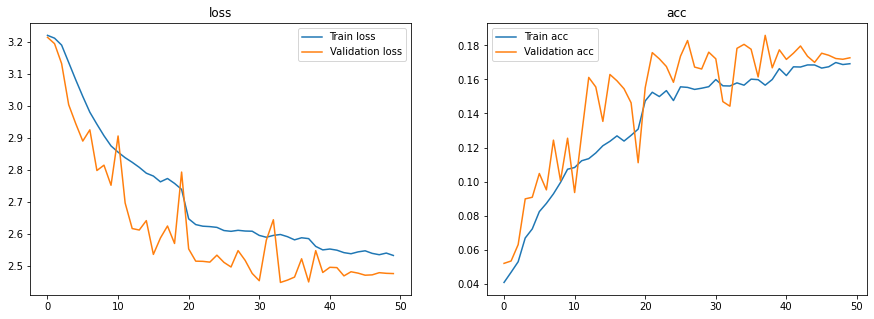

In [42]:
show_final_history(history)